In [17]:
"""
Label Noise Detection with Cleanlab – Jupyter Edition (fraud‑only filtering)
===========================================================================

This notebook identifies potentially mislabeled *fraud* entries in a binary
fraud vs. licit dataset using **Cleanlab**’s `find_label_issues` function. It
then re‑trains a RandomForest on the cleaned subset (only fraud labels
affected) to compare F1 performance.

Main change vs. the original:
* **Outliers (suspect labels) are removed *only* if the sample is labeled
  `fraud` (1)**. Licit rows remain untouched even if flagged by Cleanlab.
"""

'\nLabel Noise Detection with Cleanlab – Jupyter Edition (fraud‑only filtering)\n===========================================================================\n\nThis notebook identifies potentially mislabeled *fraud* entries in a binary\nfraud vs. licit dataset using **Cleanlab**’s `find_label_issues` function. It\nthen re‑trains a RandomForest on the cleaned subset (only fraud labels\naffected) to compare F1 performance.\n\nMain change vs. the original:\n* **Outliers (suspect labels) are removed *only* if the sample is labeled\n  `fraud` (1)**. Licit rows remain untouched even if flagged by Cleanlab.\n'

In [18]:
%pip install -q cleanlab tqdm matplotlib scikit-learn plotly

Note: you may need to restart the kernel to use updated packages.


In [19]:
# -----------------------------------------------------------------------------
# 1. Imports & configuration
# -----------------------------------------------------------------------------

from __future__ import annotations

import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cleanlab.filter import find_label_issues
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

In [20]:
# -----------------------------------------------------------------------------
# 1. Imports & configuration
# -----------------------------------------------------------------------------

from __future__ import annotations

import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cleanlab.filter import find_label_issues
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

# Configuration ---------------------------------------------------------------
BASE_DIR = Path("../data/processed_data")  # Adjust as needed
USE_CASE = "case_3.csv"
DATA_PATH = BASE_DIR / USE_CASE
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5

# Logging ---------------------------------------------------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
log = logging.getLogger("cleanlab-pipeline")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH}")

In [21]:
# -----------------------------------------------------------------------------
# 2. Load dataset and map labels (fraud=1, licit=0)
# -----------------------------------------------------------------------------

df = pd.read_csv(DATA_PATH)
if "class" not in df.columns:
    raise KeyError("Column 'class' not found in dataset")

le = LabelEncoder()
le.fit(df["class"])  # Expecting labels {"fraud","licit"}
if set(le.classes_) != {"fraud", "licit"}:
    raise ValueError("Expected labels 'fraud' and 'licit' only")

fraud_is_index1 = list(le.classes_).index("fraud") == 1
labels = le.transform(df["class"])  # 0/1 but check order
if not fraud_is_index1:
    labels = 1 - labels  # Flip so fraud=1, licit=0
log.info("Label encoding: %s -> [0,1] if fraud at index1? %s", list(le.classes_), fraud_is_index1)
log.info("Class counts: %s", dict(pd.Series(labels).value_counts()))

df["y"] = labels
X = df.drop(columns=["class", "y"]).values
y = df["y"].values

2025-06-12 08:24:33,158 [INFO] Label encoding: ['fraud', 'licit'] -> [0,1] if fraud at index1? False
2025-06-12 08:24:33,159 [INFO] Class counts: {0: 7152, 1: 6343}


In [22]:
# -----------------------------------------------------------------------------
# 3. Train/test split & baseline RandomForest
# -----------------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
baseline_f1 = f1_score(y_test, y_pred)
log.info("Baseline F1 on hold‑out set: %.3f", baseline_f1)

2025-06-12 08:24:37,389 [INFO] Baseline F1 on hold‑out set: 0.912


In [23]:
# -----------------------------------------------------------------------------
# 4. Cleanlab: detect potential label issues via cross‑validated predict_proba
# -----------------------------------------------------------------------------

log.info("Running %s‑fold CV predict_proba on full dataset…", CV_FOLDS)
probs_full = cross_val_predict(
    clf, X, y, cv=CV_FOLDS, method="predict_proba", n_jobs=-1
)

noise_indices_all = find_label_issues(
    labels=y, pred_probs=probs_full, return_indices_ranked_by="self_confidence"
)

# Keep only indices where the current label is fraud (1) ----------------------
fraud_noise_indices = [idx for idx in noise_indices_all if y[idx] == 1]
noise_rate_fraud = len(fraud_noise_indices) / (y.sum() if y.sum() else 1)
log.info(
    "Detected %s suspect FRAUD labels (%.2f%% of fraud data)",
    len(fraud_noise_indices),
    100 * noise_rate_fraud,
)

2025-06-12 08:24:37,394 [INFO] Running 5‑fold CV predict_proba on full dataset…
2025-06-12 08:24:43,467 [INFO] Detected 121 suspect FRAUD labels (1.91% of fraud data)


In [24]:
# -----------------------------------------------------------------------------
# 5. Remove suspect FRAUD rows and retrain RandomForest on cleaned subset
# -----------------------------------------------------------------------------

mask_clean = np.ones(len(y), dtype=bool)
mask_clean[fraud_noise_indices] = False

X_clean = X[mask_clean]
y_clean = y[mask_clean]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clean, y_clean, test_size=TEST_SIZE, stratify=y_clean, random_state=RANDOM_STATE
)

clf_clean = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
clf_clean.fit(Xc_train, yc_train)

yc_pred = clf_clean.predict(Xc_test)
clean_f1 = f1_score(yc_test, yc_pred)
log.info(
    "F1 after removing suspect FRAUD labels: %.3f (Δ = %.3f)",
    clean_f1,
    clean_f1 - baseline_f1,
)


2025-06-12 08:24:47,589 [INFO] F1 after removing suspect FRAUD labels: 0.918 (Δ = 0.006)


Top 10 FRAUD indices flagged as potential label errors:
[13302, 8103, 9069, 8627, 8464, 12158, 9472, 12395, 7778, 7937]


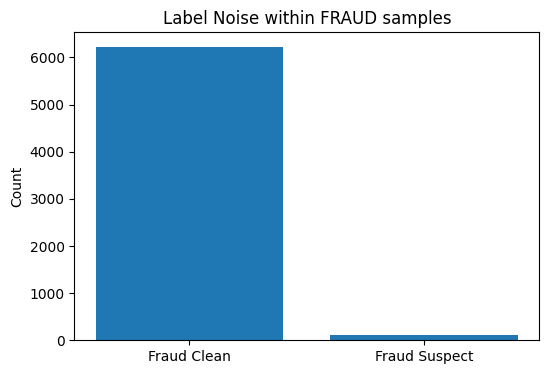

In [25]:
# -----------------------------------------------------------------------------
# 6. Display top 10 suspect FRAUD indices and plot noise vs clean counts
# -----------------------------------------------------------------------------

print("Top 10 FRAUD indices flagged as potential label errors:")
print(fraud_noise_indices[:10])

# Plot count of suspect vs clean FRAUD labels
num_fraud = y.sum()
num_suspect_fraud = len(fraud_noise_indices)
num_clean_fraud = num_fraud - num_suspect_fraud

plt.figure(figsize=(6, 4))
plt.bar(["Fraud Clean", "Fraud Suspect"], [num_clean_fraud, num_suspect_fraud])
plt.title("Label Noise within FRAUD samples")
plt.ylabel("Count")
plt.show()